<a href="https://colab.research.google.com/github/rakshitgupta22/predicting-emotions/blob/main/Predicting_Emotions_from_Sound_Events_Using_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Load packages:**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [ ]:
#1 Code to read csv file into colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#2. Get the file
#make sure you upload all your data files to your Google drive and change share->Advanced->change->anyone with the link can view
downloaded = drive.CreateFile({'id':'1sriupReVhRh5EK2w41QQizYFWj_P0d8z'}) # replace the id with id of file you want to access
downloaded.GetContentFile('EmoSounds.csv') 

downloaded = drive.CreateFile({'id':'1A9yZXyZx5ugZjj7s5Mi-Nb2UWXV2aE6f'}) 
downloaded.GetContentFile('IADSED.csv') 


<a name='load_data'></a>

### 1.1 EmoSounds Dataset Preprocessing

---

Import the csv into a pandas DataFrame.

In [ ]:
# Read EmoSounds.csv into a DataFrame.
emo_sounds_file = 'EmoSounds.csv'

emo_sounds = pd.read_csv(emo_sounds_file)
emo_sounds.head(5)

,dataset,fnames,genre,splits,vocals,arousal,valence,dynamics_rms_mean,dynamics_rms_std,pitch_pitch_mean,...,timbre_lowenergy_mean,timbre_lowenergy_std,timbre_spectralflux_mean,timbre_spectralflux_std,tonal_hcdf_mean,tonal_hcdf_std,tonal_keyclarity_mean,tonal_keyclarity_std,tonal_mode_mean,tonal_mode_std
0,Emo_Soundscapes,r_0human101979_1313063-hq.wav,human,train,Yes,-0.518549,0.302556,0.013444,0.005903,375.990904,...,5.415367,1.558017,10.204444,5.785453,0.244838,0.321193,0.457834,0.171750,-0.043605,0.068892
1,Emo_Soundscapes,r_0human102617_425689-hq.wav,human,train,No,-0.929101,0.564716,0.011291,0.008784,855.112001,...,4.652187,0.537740,9.799859,8.441237,0.629594,0.341241,0.440244,0.132387,-0.023940,0.098591
2,Emo_Soundscapes,r_0human106261_1707984-hq.wav,human,train,Yes,-0.940643,0.345425,0.000291,0.000261,494.090737,...,5.317143,1.175990,0.310226,0.342690,0.451562,0.433910,0.416266,0.162932,-0.032507,0.094219
3,Emo_Soundscapes,r_0human106568_7037-hq.wav,human,train,Yes,0.475680,0.193735,0.052846,0.028216,739.893910,...,4.998831,1.429992,45.529733,29.307053,0.337036,0.215957,0.465368,0.129338,-0.031692,0.096302
4,Emo_Soundscapes,r_0human113598_1015240-hq.wav,human,train,Yes,0.901072,0.429514,0.087529,0.020352,630.302807,...,4.937357,1.028468,67.812560,16.124870,0.195859,0.101366,0.576344,0.150061,-0.086635,0.111011


In [ ]:
emo_sounds.shape

(600, 75)

In [ ]:
# Get all the columns which have missing values

emo_null_count = emo_sounds.isnull().sum()
emo_null_count[emo_null_count > 0].sort_values(ascending = False)
## There are no missing values in EmoSounds dataset.

Series([], dtype: int64)

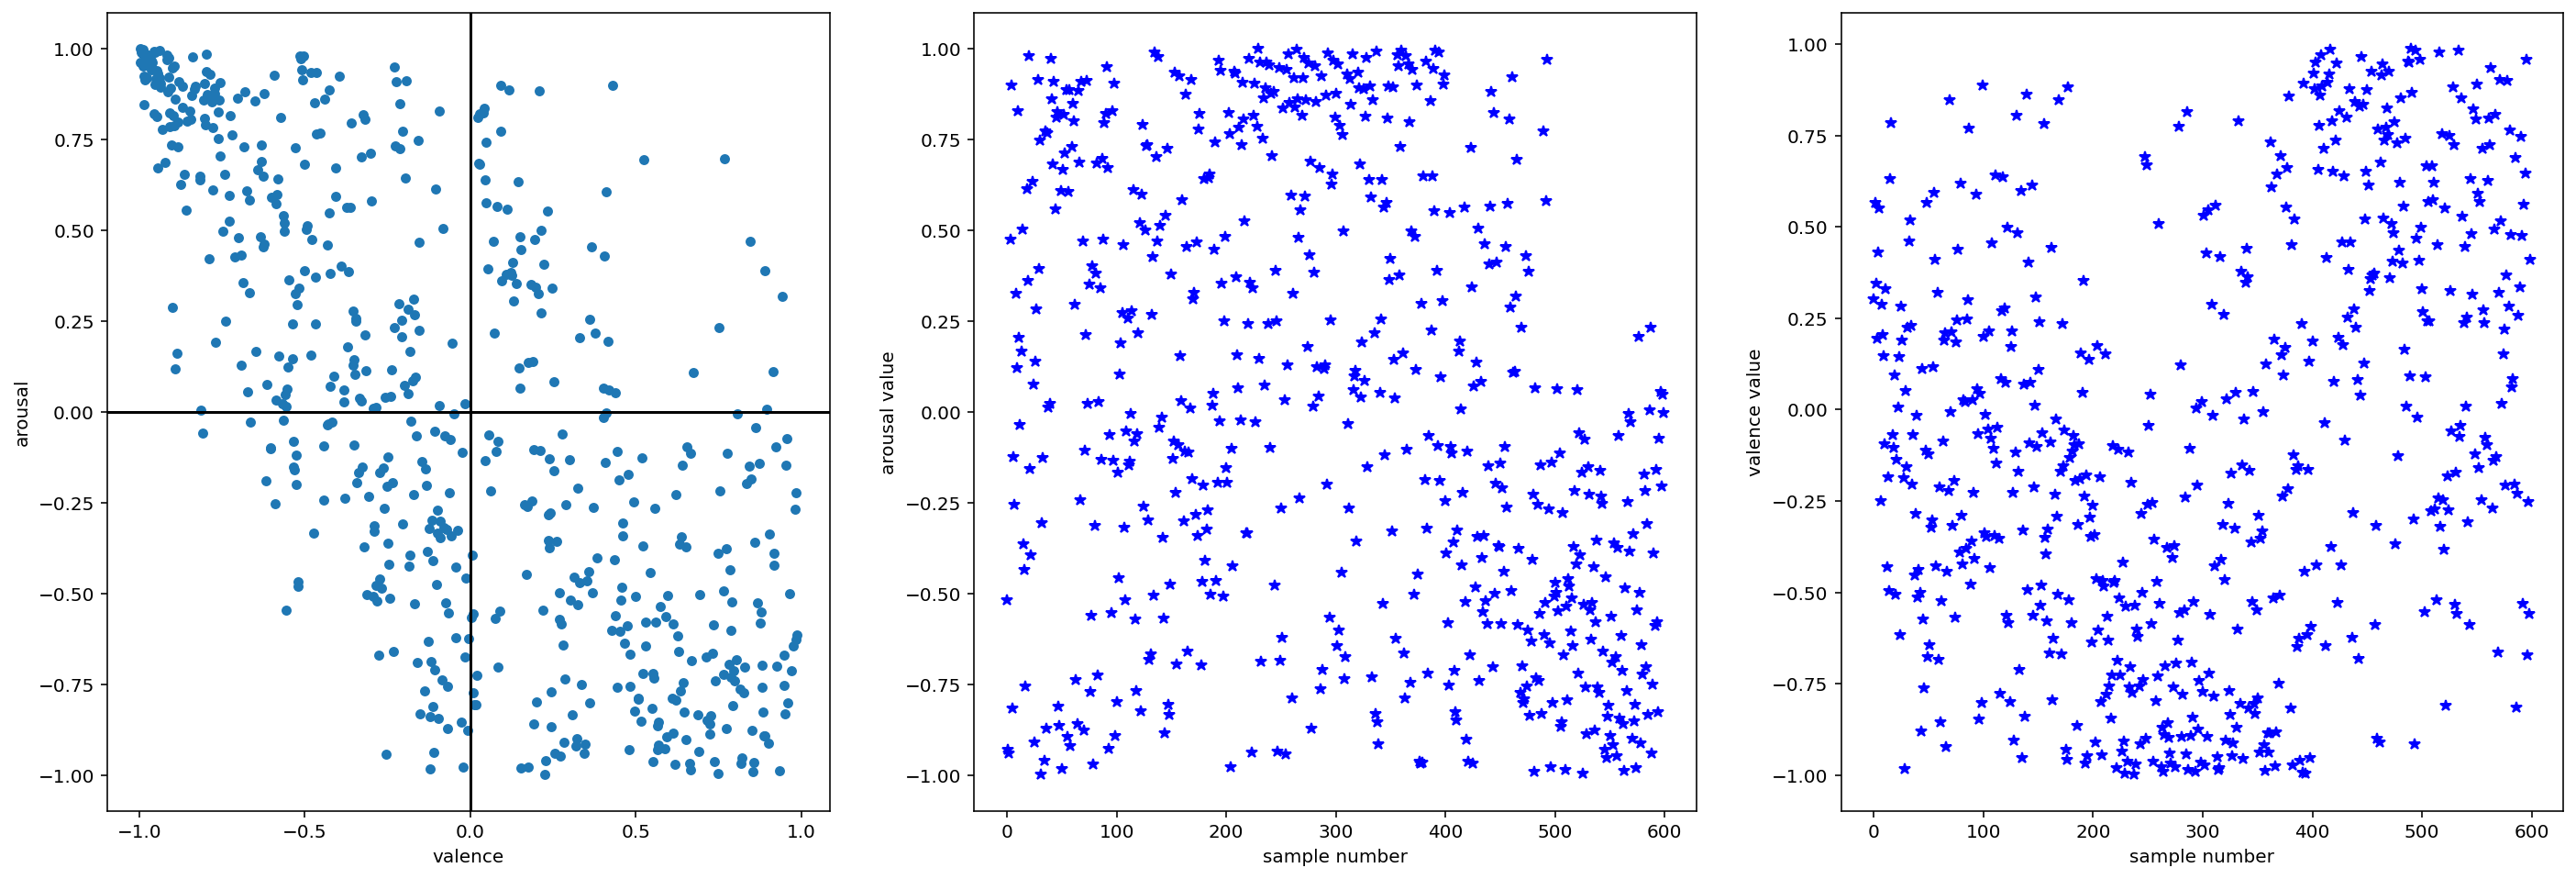

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(24,8))
plt.rcParams['font.size'] = '15'
emo_plot = emo_sounds.plot(ax=axes[0], kind='scatter', y='arousal', x='valence');
emo_plot.axhline(0, color = 'black')
emo_plot.axvline(0, color = 'black')
emo_sounds['arousal'].plot(ax=axes[1], kind='line', style='*b', xlabel='sample number', ylabel='arousal value');
emo_sounds['valence'].plot(ax=axes[2], kind='line', style='*b', xlabel='sample number', ylabel='valence value');

In [ ]:
print('The maximum value of arousal is {}'.format(emo_sounds['arousal'].max()))
print('The minimum value of arousal is {}'.format(emo_sounds['arousal'].min()))
print('The maximum value of valence is {}'.format(emo_sounds['valence'].max()))
print('The minimum value of valence is {}'.format(emo_sounds['valence'].min()))

The maximum value of arousal is 1.0
The minimum value of arousal is -0.998351195
The maximum value of valence is 0.986809563
The minimum value of valence is -0.998351195


In [ ]:
# No need to Map the 'arousal' and 'valence' to value range of (-1, 1)

In [ ]:
# Create a new dataset with labels
emo_new = emo_sounds.assign(targetColumn = 0)
emo_new.loc[(emo_new['arousal']>=0) & (emo_new['valence']>=0), 'targetColumn'] = '1'  # High-Arousal, Positive-Valence
emo_new.loc[(emo_new['arousal']>=0) & (emo_new['valence']<0), 'targetColumn'] = '2'   # High-Arousal, Negative-Valence
emo_new.loc[(emo_new['arousal']<0) & (emo_new['valence']<0), 'targetColumn'] = '3'    # Low-Arousal, Negative-Valence
emo_new.loc[(emo_new['arousal']<0) & (emo_new['valence']>=0), 'targetColumn'] = '4'   # Low-Arousal, Positive-Valence

In [ ]:
# Shift the 'label' column ahead for better visualization.
label = emo_new.pop('targetColumn')
emo_new.insert(7, 'targetColumn', label)
emo_new.head()

,dataset,fnames,genre,splits,vocals,arousal,valence,targetColumn,dynamics_rms_mean,dynamics_rms_std,...,timbre_lowenergy_mean,timbre_lowenergy_std,timbre_spectralflux_mean,timbre_spectralflux_std,tonal_hcdf_mean,tonal_hcdf_std,tonal_keyclarity_mean,tonal_keyclarity_std,tonal_mode_mean,tonal_mode_std
0,Emo_Soundscapes,r_0human101979_1313063-hq.wav,human,train,Yes,-0.518549,0.302556,4,0.013444,0.005903,...,5.415367,1.558017,10.204444,5.785453,0.244838,0.321193,0.457834,0.171750,-0.043605,0.068892
1,Emo_Soundscapes,r_0human102617_425689-hq.wav,human,train,No,-0.929101,0.564716,4,0.011291,0.008784,...,4.652187,0.537740,9.799859,8.441237,0.629594,0.341241,0.440244,0.132387,-0.023940,0.098591
2,Emo_Soundscapes,r_0human106261_1707984-hq.wav,human,train,Yes,-0.940643,0.345425,4,0.000291,0.000261,...,5.317143,1.175990,0.310226,0.342690,0.451562,0.433910,0.416266,0.162932,-0.032507,0.094219
3,Emo_Soundscapes,r_0human106568_7037-hq.wav,human,train,Yes,0.475680,0.193735,1,0.052846,0.028216,...,4.998831,1.429992,45.529733,29.307053,0.337036,0.215957,0.465368,0.129338,-0.031692,0.096302
4,Emo_Soundscapes,r_0human113598_1015240-hq.wav,human,train,Yes,0.901072,0.429514,1,0.087529,0.020352,...,4.937357,1.028468,67.812560,16.124870,0.195859,0.101366,0.576344,0.150061,-0.086635,0.111011


In [ ]:
# Check the numbers of each category---- Imbalanced 
emo_new['targetColumn'].value_counts()

2    232
4    205
3    101
1     62
Name: targetColumn, dtype: int64

In [ ]:
# Min Max Normalization
num_cols = list(emo_new.select_dtypes(include=[np.number]).columns.values)
num_cols.remove('arousal')
num_cols.remove('valence')
normalized_emo_sound_min_max = emo_new.copy()

normalized_emo_sound_min_max[num_cols] = (emo_new[num_cols]-emo_new[num_cols].min())/(emo_new[num_cols].max() - emo_new[num_cols].min())

# Change to a shorter name
emo = normalized_emo_sound_min_max
emo.head()

,dataset,fnames,genre,splits,vocals,arousal,valence,targetColumn,dynamics_rms_mean,dynamics_rms_std,...,timbre_lowenergy_mean,timbre_lowenergy_std,timbre_spectralflux_mean,timbre_spectralflux_std,tonal_hcdf_mean,tonal_hcdf_std,tonal_keyclarity_mean,tonal_keyclarity_std,tonal_mode_mean,tonal_mode_std
0,Emo_Soundscapes,r_0human101979_1313063-hq.wav,human,train,Yes,-0.518549,0.302556,4,0.021317,0.024205,...,0.441651,0.393137,0.019267,0.022736,0.300451,0.473395,0.584372,0.563060,0.421966,0.430271
1,Emo_Soundscapes,r_0human102617_425689-hq.wav,human,train,No,-0.929101,0.564716,4,0.017856,0.036140,...,0.159645,0.056379,0.018493,0.033291,0.777505,0.504023,0.560661,0.418816,0.477124,0.626211
2,Emo_Soundscapes,r_0human106261_1707984-hq.wav,human,train,Yes,-0.940643,0.345425,4,0.000177,0.000833,...,0.405356,0.267044,0.000341,0.001105,0.556765,0.645596,0.528339,0.530746,0.453095,0.597366
3,Emo_Soundscapes,r_0human106568_7037-hq.wav,human,train,Yes,0.475680,0.193735,1,0.084644,0.116640,...,0.287735,0.350881,0.086838,0.116217,0.414766,0.312622,0.594527,0.407643,0.455381,0.611109
4,Emo_Soundscapes,r_0human113598_1015240-hq.wav,human,train,Yes,0.901072,0.429514,1,0.140388,0.084062,...,0.265019,0.218352,0.129461,0.063828,0.239722,0.137558,0.744121,0.483581,0.301274,0.708152


<a name='Train'></a>

### 1.2 EmoSounds Dataset Training


In [ ]:
#Shuffling the dataset
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

emo_shuffle = shuffle(emo)

X_emo = emo_shuffle.iloc[:,8:]
y_emo = emo_shuffle.iloc[:,7]

# Splitting the data into train and test sets after shuffling
# 80% 20% split
X_emo_train, X_emo_test, y_emo_train, y_emo_test,  = train_test_split(X_emo, y_emo, test_size=0.2, random_state=0)

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

def cross_validate(num_splits, X, Y, model):

  kf = KFold(n_splits=num_splits, shuffle= True, random_state=0)
  score_list = []

  for train_idx, test_idx in kf.split(X, Y):
    x_train = X.iloc[train_idx]
    y_train = Y.iloc[train_idx]

    x_test = X.iloc[test_idx]
    y_test = Y.iloc[test_idx]

    model.fit(x_train, y_train) #Training the model
    
    #Making Predictions
    y_pred = model.predict(x_test)

    #f1-score
    report = classification_report(y_test, y_pred, output_dict=True)
    score_list.append(report['macro avg']['f1-score'])
    
  return score_list

<a name='Logistic regression'></a>

#### 1.2.1 Logistic Regression

In [ ]:
#Logistic Regression with Linear Features

from sklearn.linear_model import LogisticRegression

# Fitting Logistic Regression to training set
logM_emo = LogisticRegression(penalty='none', solver='saga', random_state=0)
logM_emo.fit(X_emo_train, y_emo_train)

# Making predictions
y_emo_train_pred = logM_emo.predict(X_emo_train) #Training set
y_emo_test_pred = logM_emo.predict(X_emo_test) #Test set

In [ ]:
# Calculating F1-scores
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Training Report
log_report_train_emo = classification_report(y_emo_train, y_emo_train_pred)
print("Training Classification Report: Logistic Regression for Emo-soundscape dataset:\n",log_report_train_emo)

#Getting confusion matrix for Training Data
cm_emo_logM_train = confusion_matrix(y_emo_train, y_emo_train_pred, labels=logM_emo.classes_)

disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_emo_logM_train, display_labels=logM_emo.classes_)
disp_train.plot()

#Testing Report
log_report_test_emo = classification_report(y_emo_test, y_emo_test_pred)
print("Testing Classification Report: Logistic Regression for Emo-soundscape dataset:\n",log_report_test_emo)

#Getting confusion matrix for Testing Data
cm_emo_logM_test = confusion_matrix(y_emo_test, y_emo_test_pred, labels=logM_emo.classes_)

disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_emo_logM_test, display_labels=logM_emo.classes_)
disp_test.plot()

Training Classification Report: Logistic Regression for Emo-soundscape dataset:
               precision    recall  f1-score   support

           1       0.65      0.46      0.54        48
           2       0.82      0.91      0.86       185
           3       0.63      0.51      0.57        80
           4       0.80      0.84      0.82       167

    accuracy                           0.77       480
   macro avg       0.72      0.68      0.69       480
weighted avg       0.76      0.77      0.76       480

Testing Classification Report: Logistic Regression for Emo-soundscape dataset:
               precision    recall  f1-score   support

           1       0.22      0.14      0.17        14
           2       0.78      0.83      0.80        47
           3       0.47      0.43      0.45        21
           4       0.69      0.76      0.72        38

    accuracy                           0.66       120
   macro avg       0.54      0.54      0.54       120
weighted avg       0.63 

Error in callback <function flush_figures at 0x7f7f1ba0edd0> (for post_execute):


KeyboardInterrupt: ignored

In [ ]:
# Cross validation to check overfiting/underfitting

#Logistic Regression with Linear Features
logM_emo_cv = LogisticRegression(penalty='none', solver='saga', random_state=0)
f1_cv_emo = cross_validate(5, X_emo, y_emo, logM_emo_cv)
print("Macro Average f1-score for each fold of Logistic Regression Model: ",f1_cv_emo)
print("Average Score: ",np.mean(f1_cv_emo))

Macro Average f1-score for each fold of Logistic Regression Model:  [0.5382591887046168, 0.48789915966386554, 0.48730158730158735, 0.45683183183183185, 0.47824684003513196]
Average Score:  0.48970772150740666


In [ ]:
#logistic Regression with Polynomial Features of degree 2 (Can be removed since degree 1 is giving better performance)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import PolynomialFeatures
polyreg = PolynomialFeatures(degree=2)

#Generating the polynomial feature
X_poly = polyreg.fit_transform(X_emo_train)

# Fitting Logistic Regression to training set
logM_emo_poly = LogisticRegression(penalty='none', solver='saga', random_state=0)
logM_emo_poly.fit(X_poly, y_emo_train)

# Making predictions
y_emo_train_pred_poly = logM_emo_poly.predict(X_poly) #Training set
y_emo_test_pred_poly = logM_emo_poly.predict(polyreg.transform(X_emo_test)) #Test set


Training Classification Report: Logistic Regression for Emo-soundscape dataset:
               precision    recall  f1-score   support

           1       0.85      0.58      0.69        48
           2       0.90      0.97      0.93       185
           3       0.89      0.71      0.79        80
           4       0.87      0.95      0.91       167

    accuracy                           0.88       480
   macro avg       0.88      0.80      0.83       480
weighted avg       0.88      0.88      0.88       480

Testing Classification Report: Logistic Regression for Emo-soundscape dataset:
               precision    recall  f1-score   support

           1       0.20      0.14      0.17        14
           2       0.79      0.79      0.79        47
           3       0.43      0.43      0.43        21
           4       0.69      0.76      0.72        38

    accuracy                           0.64       120
   macro avg       0.53      0.53      0.53       120
weighted avg       0.63 

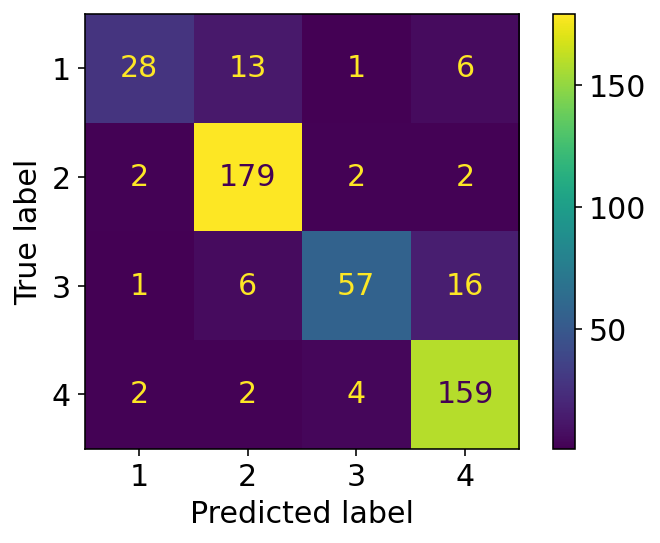

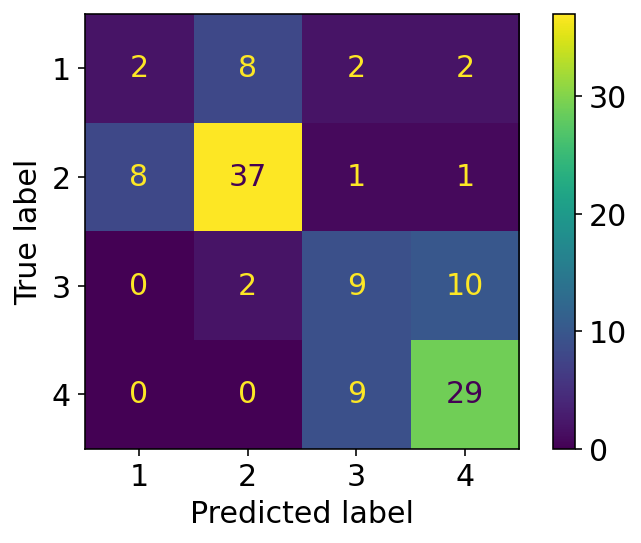

In [ ]:
# Calculating F1-scores
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Training Report
log_report_train_emo = classification_report(y_emo_train, y_emo_train_pred_poly)
print("Training Classification Report: Logistic Regression for Emo-soundscape dataset:\n",log_report_train_emo)

#Getting confusion matrix for Training Data
cm_emo_logM_train_poly = confusion_matrix(y_emo_train, y_emo_train_pred_poly, labels=logM_emo_poly.classes_)

disp_train_poly = ConfusionMatrixDisplay(confusion_matrix=cm_emo_logM_train_poly, display_labels=logM_emo_poly.classes_)
disp_train_poly.plot()

#Testing Report
log_report_test_emo = classification_report(y_emo_test, y_emo_test_pred_poly)
print("Testing Classification Report: Logistic Regression for Emo-soundscape dataset:\n",log_report_test_emo)

#Getting confusion matrix for Testing Data
cm_emo_logM_test_poly = confusion_matrix(y_emo_test, y_emo_test_pred_poly, labels=logM_emo_poly.classes_)

disp_train_poly = ConfusionMatrixDisplay(confusion_matrix=cm_emo_logM_test_poly, display_labels=logM_emo_poly.classes_)
disp_train_poly.plot()

In [ ]:
#Cross-Validation of Logistic Regression with Polynomial Features
logM_emo_poly_cv = LogisticRegression(penalty='none', solver='saga', C=0.4, random_state=0)
f1_cv_emo_poly = cross_validate(5, pd.DataFrame(polyreg.transform(X_emo)), y_emo, logM_emo_poly_cv)
print("Macro Average f1-score for each fold of Logistic Regression Model: ",f1_cv_emo_poly)
print("Average Score: ",np.mean(f1_cv_emo_poly))

Macro Average f1-score for each fold of Logistic Regression Model:  [0.5326727642276422, 0.5740808069824916, 0.4836956521739131, 0.4742021315055023, 0.5473118279569893]
Average Score:  0.5223926365693077


<a name='RandomForestClassifier'></a>

#### 1.2.2 RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Splitting the dataset into Train, Validate and Test sets for tuning Random Forest into a 60, 20, 20 split (split the train set into 0.75 0.25 to achieve it)
X_emo_train_rf, X_emo_val_rf, y_emo_train_rf, y_emo_val_rf,  = train_test_split(X_emo_train, y_emo_train, test_size=0.25, random_state=0)

In [ ]:
# Train model using training set
#min_samples_leaf = 1 overfits the model

rf_emo_validate = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=5, criterion='entropy', random_state=0)
rf_emo_validate.fit(X_emo_train_rf, y_emo_train_rf)

# Evaluation using validation set: Making predictions 
y_emo_val_pred_rf = rf_emo_validate.predict(X_emo_val_rf) #Validation set
y_emo_train_pred_rf = rf_emo_validate.predict(X_emo_train_rf) #Training set

Training Classification Report: Logistic Regression for Emo-soundscape dataset:
               precision    recall  f1-score   support

           1       1.00      0.62      0.77        37
           2       0.88      0.97      0.92       143
           3       0.93      0.77      0.84        56
           4       0.89      0.96      0.92       124

    accuracy                           0.90       360
   macro avg       0.93      0.83      0.86       360
weighted avg       0.90      0.90      0.89       360

Validation Classification Report: Logistic Regression for Emo-soundscape dataset:
               precision    recall  f1-score   support

           1       0.25      0.09      0.13        11
           2       0.69      0.86      0.77        42
           3       0.67      0.17      0.27        24
           4       0.69      0.93      0.79        43

    accuracy                           0.68       120
   macro avg       0.57      0.51      0.49       120
weighted avg       0.

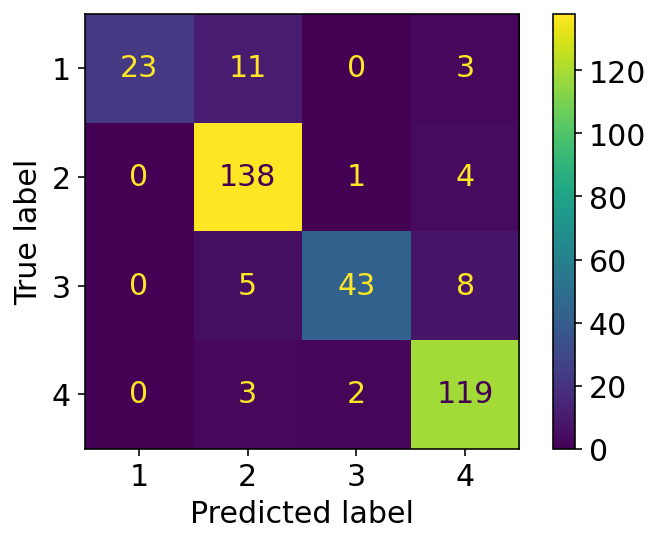

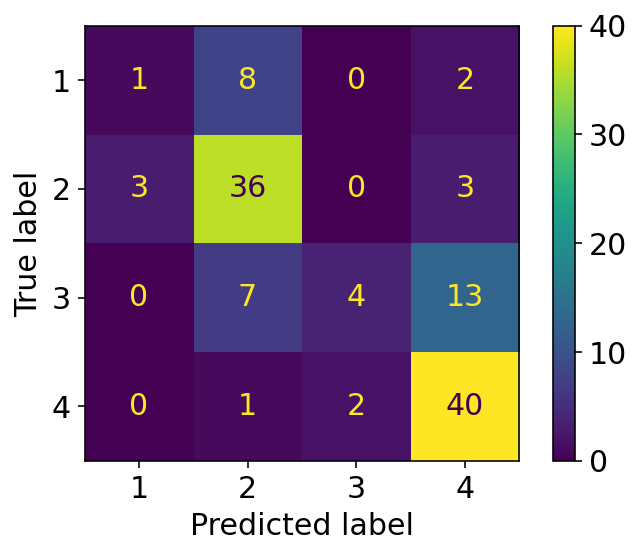

In [ ]:
# Calculating F1-scores

#Training Report
rf_report_train_emo = classification_report(y_emo_train_rf, y_emo_train_pred_rf)
print("Training Classification Report: Logistic Regression for Emo-soundscape dataset:\n",rf_report_train_emo)

#Getting confusion matrix for Training Data
cm_emo_rf_train = confusion_matrix(y_emo_train_rf, y_emo_train_pred_rf, labels=rf_emo_validate.classes_)

disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_emo_rf_train, display_labels=rf_emo_validate.classes_)
disp_train.plot()

#Validation Report
rf_report_validate_emo = classification_report(y_emo_val_rf, y_emo_val_pred_rf)
print("Validation Classification Report: Logistic Regression for Emo-soundscape dataset:\n",rf_report_validate_emo)

#Getting confusion matrix for Training Data
cm_emo_rf_validation = confusion_matrix(y_emo_val_rf, y_emo_val_pred_rf, labels=rf_emo_validate.classes_)

disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_emo_rf_validation, display_labels=rf_emo_validate.classes_)
disp_train.plot()

Training Classification Report: Random Forest Classification for Emo-soundscape dataset:
               precision    recall  f1-score   support

           1       1.00      0.71      0.83        48
           2       0.92      0.99      0.95       185
           3       0.95      0.75      0.84        80
           4       0.89      0.98      0.93       167

    accuracy                           0.92       480
   macro avg       0.94      0.86      0.89       480
weighted avg       0.92      0.92      0.91       480

Testing Classification Report: Logistic Regression for Emo-soundscape dataset:
               precision    recall  f1-score   support

           1       1.00      0.07      0.13        14
           2       0.67      0.96      0.79        47
           3       0.43      0.14      0.21        21
           4       0.69      0.82      0.75        38

    accuracy                           0.67       120
   macro avg       0.70      0.50      0.47       120
weighted avg   

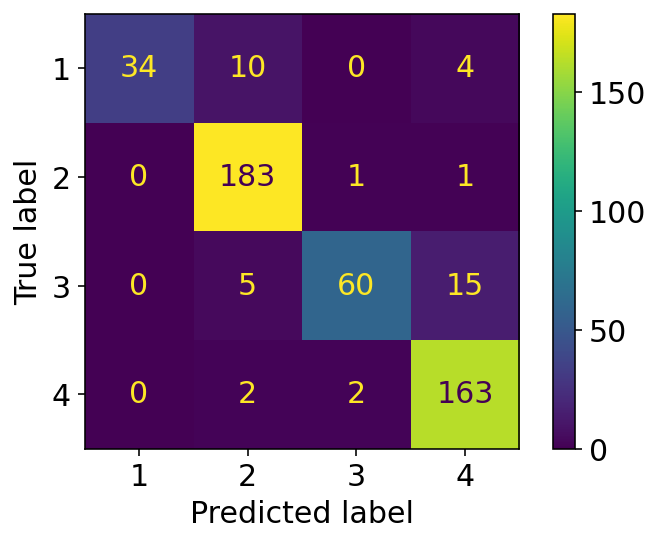

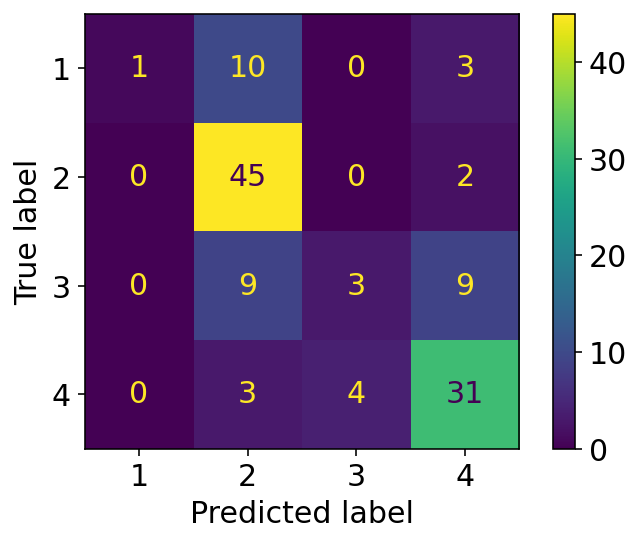

In [ ]:
# Train model again using training and validation set
rf_emo = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=5, criterion='entropy', random_state=0)
rf_emo.fit(X_emo_train, y_emo_train)

# Making predictions 
y_emo_train_pred_rf = rf_emo.predict(X_emo_train) #Training set
y_emo_test_pred_rf = rf_emo.predict(X_emo_test) #Test set

# Calculating F1-scores

#Training Report
rf_report_train_emo = classification_report(y_emo_train, y_emo_train_pred_rf)
print("Training Classification Report: Random Forest Classification for Emo-soundscape dataset:\n",rf_report_train_emo)

#Getting confusion matrix for Training Data
cm_emo_rf_train = confusion_matrix(y_emo_train, y_emo_train_pred_rf, labels=rf_emo.classes_)

disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_emo_rf_train, display_labels=rf_emo.classes_)
disp_train.plot()

#Testing Report
rf_report_test_emo = classification_report(y_emo_test, y_emo_test_pred_rf)
print("Testing Classification Report: Logistic Regression for Emo-soundscape dataset:\n",rf_report_test_emo)

#Getting confusion matrix for Testing Data
cm_emo_rf_test = confusion_matrix(y_emo_test, y_emo_test_pred_rf, labels=rf_emo.classes_)

disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_emo_rf_test, display_labels=rf_emo.classes_)
disp_test.plot()

In [ ]:
#Cross validation to check overfiting/underfitting
f1_cv_emo_rf = cross_validate(5, X_emo, y_emo, rf_emo)
print("Macro Average F1-score for each fold of Logistic Regression Model: ",f1_cv_emo_rf)
print("Average f1-score: ",np.mean(f1_cv_emo_rf))

Macro Average F1-score for each fold of Logistic Regression Model:  [0.44287357112292924, 0.5690128884280226, 0.484779404992171, 0.42171052631578954, 0.48632206542581896]
Average f1-score:  0.48093969125694624


<a name='Feature selection'></a>

### 1.3 Feature selection


<a name='load_data'></a>

#### 1.3.1 Filter method


In [ ]:
# original X_emo_train shape
X_emo_train.shape

(480, 68)

In [ ]:
type(X_emo_train)

pandas.core.frame.DataFrame

In [ ]:
# Removing Constant features using VarianceThreshold

from sklearn.feature_selection import VarianceThreshold

constant_filter = VarianceThreshold(threshold=0)

#Fit and transforming on train data
data_constant = constant_filter.fit_transform(X_emo_train)

#Extracting all constant columns using get support function of our filter
constant_columns = [column for column in X_emo_train.columns
                   if column not in X_emo_train.columns[constant_filter.get_support()]]

#No. of constant columns
print(len(constant_columns))
print("No constant features were found.")


0
No constant features were found.


In [ ]:
# Removing Quasi-Constant Features

qcons_filter = VarianceThreshold(threshold=0.01)

#Fitand transforming on train data
data_qcons = qcons_filter.fit_transform(X_emo_train)

#Extracting all Quasi constant columns using get support function of our filter
qcons_columns = [column for column in X_emo_train.columns
                    if column not in X_emo_train.columns[qcons_filter.get_support()]]

#No. of Quasi constant columns
print(len(qcons_columns)) 
print(f'{len(qcons_columns)} quasi-constant features were found.')

#Removing identified quasi-constant columns
X_emo_train1 = X_emo_train.drop(qcons_columns,axis=1)
X_emo_test1 = X_emo_test.drop(qcons_columns,axis=1)
print(X_emo_train1.shape)
print(X_emo_test1.shape)

13
13 quasi-constant features were found.
(480, 55)
(120, 55)


<a name='Training with selected features'></a>

##### 1.3.1.1  Logistic Regression

In [ ]:
#chi2 is used when both input and output are categorical, f_classif refers to ANOVA. 
#Reference - https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# feature selection
def select_features(X_train, y_train, X_test, num):
	# configure to select "num" features
	fs = SelectKBest(score_func=f_classif, k=num)
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

In [ ]:
# Select K best features, change "num" to get the best results.
X_emo_train_logM_filter, X_emo_test_logM_filter, fs_logM_filter = select_features(X_emo_train1, y_emo_train, X_emo_test1, 40)

Training Classification Report: Logistic Regression (After Feature Selection) for Emo-soundscape dataset:
               precision    recall  f1-score   support

           1       0.57      0.27      0.37        48
           2       0.78      0.90      0.83       185
           3       0.53      0.34      0.41        80
           4       0.74      0.85      0.79       167

    accuracy                           0.73       480
   macro avg       0.65      0.59      0.60       480
weighted avg       0.70      0.72      0.70       480

Testing Classification Report: Logistic Regression (After Feature Selection) for Emo-soundscape dataset:
               precision    recall  f1-score   support

           1       0.55      0.43      0.48        14
           2       0.84      0.87      0.85        47
           3       0.42      0.38      0.40        21
           4       0.68      0.74      0.71        38

    accuracy                           0.69       120
   macro avg       0.62   

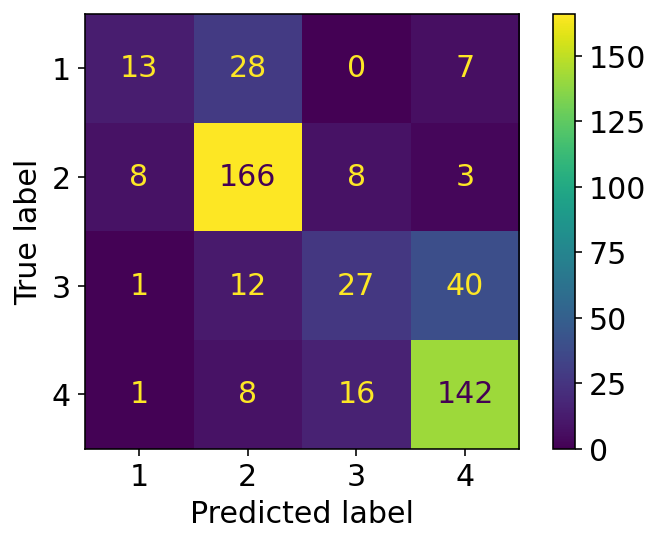

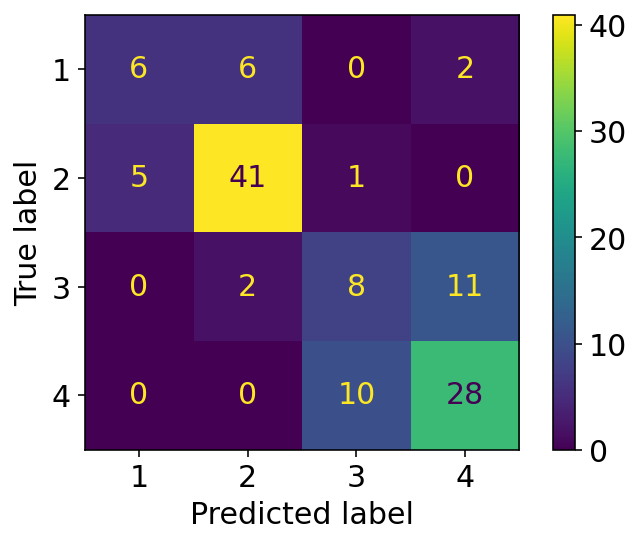

In [ ]:
#Fitting Logistic Regression to training set
logM_emo_filter = LogisticRegression(penalty='none', solver='saga', random_state=0)
logM_emo_filter.fit(X_emo_train_logM_filter, y_emo_train)

#Making predictions
y_emo_train_pred_filter = logM_emo_filter.predict(X_emo_train_logM_filter) #Training set
y_emo_test_pred_filter = logM_emo_filter.predict(X_emo_test_logM_filter) #Test set

# Calculating F1-scores

#Training Report
logM_report_train_emo_filter = classification_report(y_emo_train, y_emo_train_pred_filter)
print("Training Classification Report: Logistic Regression (After Feature Selection) for Emo-soundscape dataset:\n",logM_report_train_emo_filter)

#Getting confusion matrix for Training Data
cm_emo_logM_train_filter = confusion_matrix(y_emo_train, y_emo_train_pred_filter, labels=logM_emo_filter.classes_)

disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_emo_logM_train_filter, display_labels=logM_emo_filter.classes_)
disp_train.plot()

#Testing Report
logM_report_test_emo_filter = classification_report(y_emo_test, y_emo_test_pred_filter)
print("Testing Classification Report: Logistic Regression (After Feature Selection) for Emo-soundscape dataset:\n",logM_report_test_emo_filter)

#Getting confusion matrix for Testing Data
cm_emo_logM_test_filter = confusion_matrix(y_emo_test, y_emo_test_pred_filter, labels=logM_emo_filter.classes_)

disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_emo_logM_test_filter, display_labels=logM_emo_filter.classes_)
disp_test.plot()

In [ ]:
# Cross validation to check overfiting/underfitting
df1 = pd.DataFrame(X_emo_train_logM_filter)
f1_cv_emo_logM_filter = cross_validate(5, df1, y_emo_train, logM_emo_filter)
print("Macro Average F1-score for each fold of Logistic Regression Model: ",f1_cv_emo_logM_filter)
print("Average F1-score: ",np.mean(f1_cv_emo_logM_filter))

Macro Average F1-score for each fold of Logistic Regression Model:  [0.45894764957264955, 0.5278502415458937, 0.5047600930035934, 0.46557439271255063, 0.5412354281309214]
Average F1-score:  0.49967356099312166


<a name='Training with selected features'></a>

##### 1.3.1.2  RandomForestClassifier

In [ ]:
# Select K best features, change "num" to get the best results.
X_emo_train_rf_filter, X_emo_test_rf_filter, fs_rf_filter = select_features(X_emo_train1, y_emo_train, X_emo_test1, 40)

In [ ]:
#Use GridSearch to fine tune model

from sklearn.model_selection import GridSearchCV

rf_filter = RandomForestClassifier()
tune_paragm = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 50, 100],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [2, 3, 5],
    'criterion': ['gini', 'entropy']
}
rf_gdcv_filter = GridSearchCV(rf_filter, tune_paragm, n_jobs=-1, cv=5, scoring='f1_macro')
rf_gdcv_filter.fit(X_emo_train_rf_filter, y_emo_train)

KeyboardInterrupt: ignored

In [ ]:
# Get the best parameters
rf_gdcv_filter.best_params_

# Save the seed

# num=30: 'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 50
# num=45: 'criterion': 'gini', 'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 50
# num=40: 'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50
# num=35: 'criterion': 'gini', 'max_depth': 100, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100

In [ ]:
rf_emo_filter = RandomForestClassifier(n_estimators=50, max_depth=10, min_samples_split=5, min_samples_leaf=2, criterion='entropy', random_state=0)
rf_emo_filter.fit(X_emo_train_rf_filter, y_emo_train)

# Making predictions 
y_emo_train_pred_rf_filter = rf_emo_filter.predict(X_emo_train_rf_filter) #Training set
y_emo_test_pred_rf_filter = rf_emo_filter.predict(X_emo_test_rf_filter) #Test set

# Calculating F1-scores

#Training Report
rf_report_train_emo_filter = classification_report(y_emo_train, y_emo_train_pred_rf_filter)
print("Training Classification Report: Random Forest (After Feature Selection) for Emo-soundscape dataset:\n",rf_report_train_emo_filter)

#Getting confusion matrix for Training Data
cm_emo_rf_train_filter = confusion_matrix(y_emo_train, y_emo_train_pred_rf_filter, labels=rf_emo_filter.classes_)

disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_emo_rf_train_filter, display_labels=rf_emo_filter.classes_)
disp_train.plot()

#Testing Report
rf_report_test_emo_filter = classification_report(y_emo_test, y_emo_test_pred_rf_filter)
print("Testing Classification Report: Random Forest (After Feature Selection) for Emo-soundscape dataset:\n",rf_report_test_emo_filter)

#Getting confusion matrix for Testing Data
cm_emo_rf_test_filter = confusion_matrix(y_emo_test, y_emo_test_pred_rf_filter, labels=rf_emo_filter.classes_)

disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_emo_rf_test_filter, display_labels=rf_emo_filter.classes_)
disp_test.plot()

In [ ]:
# Cross validation to check overfiting/underfitting
df2 = pd.DataFrame(X_emo_train_rf_filter)
f1_cv_emo_rf_filter = cross_validate(5, df2, y_emo_train, rf_emo_filter)
print("Macro Average f1-score for each fold of Logistic Regression Model: ",f1_cv_emo_rf_filter)
print("Average macro Score: ",np.mean(f1_cv_emo_rf_filter))

<a name='load_data'></a>

#### 1.3.2 Boruta Algorithm


In [ ]:
# Install and Import Boruta Library
!pip install boruta
from boruta import BorutaPy

In [ ]:
X_emo_train.shape

In [ ]:
###initialize Boruta
forest = RandomForestClassifier(n_jobs = -1)
boruta = BorutaPy(estimator = forest, n_estimators = 'auto', max_iter = 100)

### fit Boruta (it accepts np.array, not pd.DataFrame)
boruta.fit(np.array(X_emo_train), np.array(y_emo_train))
### print results
green_area = X_emo_train.columns[boruta.support_].to_list()
blue_area = X_emo_train.columns[boruta.support_weak_].to_list()

print('number of features in the green area:', len(green_area))
print(green_area)
print('number of features in the blue area:', len(blue_area))
print(blue_area)

boruta_selected_features = green_area + blue_area

<a name='Training with selected features'></a>

##### 1.3.2.1  Logistic Regression

In [ ]:
#Fitting Logistic Regression to training set
logM_emo_boruta = LogisticRegression(penalty='none', solver='saga', random_state=0)
logM_emo_boruta.fit(X_emo_train[boruta_selected_features], y_emo_train)

#Making predictions
y_emo_train_pred_boruta = logM_emo_boruta.predict(X_emo_train[boruta_selected_features]) #Training set
y_emo_test_pred_boruta = logM_emo_boruta.predict(X_emo_test[boruta_selected_features]) #Test set

# Calculating F1-scores

#Training Report
logM_report_train_emo_boruta = classification_report(y_emo_train, y_emo_train_pred_boruta)
print("Training Classification Report: Logistic Regression (After Feature Selection) for Emo-soundscape dataset:\n",logM_report_train_emo_boruta)

#Getting confusion matrix for Training Data
cm_emo_logM_train_boruta = confusion_matrix(y_emo_train, y_emo_train_pred_boruta, labels=logM_emo_boruta.classes_)

disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_emo_logM_train_boruta, display_labels=logM_emo_boruta.classes_)
disp_train.plot()

#Testing Report
logM_report_test_emo_boruta = classification_report(y_emo_test, y_emo_test_pred_boruta)
print("Testing Classification Report: Logistic Regression (After Feature Selection) for Emo-soundscape dataset:\n",logM_report_test_emo_boruta)

#Getting confusion matrix for Testing Data
cm_emo_logM_test_boruta = confusion_matrix(y_emo_test, y_emo_test_pred_boruta, labels=logM_emo_boruta.classes_)

disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_emo_logM_test_boruta, display_labels=logM_emo_boruta.classes_)
disp_test.plot()

In [ ]:
# Cross validation to check overfiting/underfitting
df3 = pd.DataFrame(X_emo_train[boruta_selected_features])
f1_cv_emo_logM_boruta = cross_validate(5, df3, y_emo_train, logM_emo_boruta)
print("Macro Average F1-score for each fold of Logistic Regression Model: ",f1_cv_emo_logM_boruta)
print("Average F1-score: ",np.mean(f1_cv_emo_logM_filter))

<a name='Training with selected features'></a>

##### 1.3.2.2  RandomForestClassifier

In [ ]:
#Use GridSearch to fine tune Random Forest model

rf_boruta = RandomForestClassifier()
tune_paragm = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 50, 100],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [2, 3, 5],
    'criterion': ['gini', 'entropy']
}
rf_gdcv_boruta = GridSearchCV(rf_boruta, tune_paragm, n_jobs=-1, cv=5)
rf_gdcv_boruta.fit(X_emo_train[boruta_selected_features], y_emo_train)

print(rf_gdcv_boruta.best_params_)

In [ ]:
rf_emo_boruta = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=2, min_samples_leaf=5, criterion='entropy', random_state=0)
rf_emo_boruta.fit(X_emo_train[boruta_selected_features], y_emo_train)

# Making predictions 
y_emo_train_pred_rf_boruta = rf_emo_boruta.predict(X_emo_train[boruta_selected_features]) #Training set
y_emo_test_pred_rf_boruta = rf_emo_boruta.predict(X_emo_test[boruta_selected_features]) #Test set

# Calculating F1-scores

#Training Report
rf_report_train_emo_boruta = classification_report(y_emo_train, y_emo_train_pred_rf_boruta)
print("Training Classification Report: Random Forest (After Feature Selection) for Emo-soundscape dataset:\n",rf_report_train_emo_boruta)

#Getting confusion matrix for Training Data
cm_emo_rf_train_boruta = confusion_matrix(y_emo_train, y_emo_train_pred_rf_boruta, labels=rf_emo_boruta.classes_)

disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_emo_rf_train_boruta, display_labels=rf_emo_boruta.classes_)
disp_train.plot()

#Testing Report
rf_report_test_emo_boruta = classification_report(y_emo_test, y_emo_test_pred_rf_boruta)
print("Testing Classification Report: Random Forest (After Feature Selection) for Emo-soundscape dataset:\n",rf_report_test_emo_boruta)

#Getting confusion matrix for Testing Data
cm_emo_rf_test_boruta = confusion_matrix(y_emo_test, y_emo_test_pred_rf_boruta, labels=rf_emo_boruta.classes_)

disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_emo_rf_test_boruta, display_labels=rf_emo_boruta.classes_)
disp_test.plot()

In [ ]:
# Cross validation to check overfiting/underfitting
f1_cv_emo_rf_boruta = cross_validate(5, df3, y_emo_train, rf_emo_boruta)
print("Macro Average F1-score  for each fold of Logistic Regression Model: ",f1_cv_emo_rf_boruta)
print("Average F1-score: ",np.mean(f1_cv_emo_rf_boruta))

<a name='load_data'></a>

### 2.1 IADSE Dataset Preprocessing

---

Import the csv into a pandas DataFrame.

In [ ]:
# Read IADSE.csv into a DataFrame.
iadsed_file = 'IADSED.csv'

iadse = pd.read_csv(iadsed_file)
iadse.head(5)

In [ ]:
iadse.shape

In [ ]:
# Get all the columns which have missing values
iad_null_count = iadse.isnull().sum()
iad_null_count[iad_null_count > 0].sort_values(ascending = False)

In [ ]:
# Drop the rows with null values
iadse = iadse.dropna(how='any',axis=0)

In [ ]:
# Check again, there are no more null values left.
iad_null_count = iadse.isnull().sum()
iad_null_count[iad_null_count > 0].sort_values(ascending=False)

In [ ]:
iadse.shape

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(24,8))
plt.rcParams['font.size'] = '15'
iadse.plot(ax=axes[0], kind='scatter', y='arousal', x='valence');
iadse['arousal'].plot(ax=axes[1], kind='line', style='*b', xlabel='sample number', ylabel='arousal value');
iadse['valence'].plot(ax=axes[2], kind='line', style='*b', xlabel='sample number', ylabel='valence value');

In [ ]:
print('The maximum value of arousal is {}'.format(iadse['arousal'].max()))
print('The minimum value of arousal is {}'.format(iadse['arousal'].min()))
print('The maximum value of valence is {}'.format(iadse['valence'].max()))
print('The minimum value of valence is {}'.format(iadse['valence'].min()))

In [ ]:
# Map the 'arousal' and 'valence' to value range of (-1, 1)
iadse_new=iadse.copy()
iadse_new['arousal']=(iadse_new['arousal']-iadse_new['arousal'].mean())/iadse_new['arousal'].std()
iadse_new['arousal']=iadse_new['arousal']/iadse_new['arousal'].abs().max()
iadse_new['valence']=(iadse_new['valence']-iadse_new['valence'].mean())/iadse_new['valence'].std()
iadse_new['valence']=iadse_new['valence']/iadse_new['valence'].abs().max()
print('The maximum value of arousal is {}'.format(iadse_new['arousal'].max()))
print('The minimum value of arousal is {}'.format(iadse_new['arousal'].min()))
print('The maximum value of valence is {}'.format(iadse_new['valence'].max()))
print('The minimum value of valence is {}'.format(iadse_new['valence'].min()))

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(24,8))
plt.rcParams['font.size'] = '15'
iadse_plt = iadse_new.plot(ax=axes[0], kind='scatter', y='arousal', x='valence');
iadse_plt.axhline(0, color = 'black')
iadse_plt.axvline(0, color = 'black')
iadse_new['arousal'].plot(ax=axes[1], kind='line', style='*b', xlabel='sample number', ylabel='arousal value');
iadse_new['valence'].plot(ax=axes[2], kind='line', style='*b', xlabel='sample number', ylabel='valence value');

In [ ]:
# Create a new dataset with labels
iadse_new = iadse_new.assign(targetColumn = 0)
iadse_new.loc[(iadse_new['arousal']>=0) & (iadse_new['valence']>=0), 'targetColumn'] = '1'  # High-Arousal, Positive-Valence
iadse_new.loc[(iadse_new['arousal']>=0) & (iadse_new['valence']<0), 'targetColumn'] = '2'   # High-Arousal, Negative-Valence
iadse_new.loc[(iadse_new['arousal']<0) & (iadse_new['valence']<0), 'targetColumn'] = '3'    # Low-Arousal, Negative-Valence
iadse_new.loc[(iadse_new['arousal']<0) & (iadse_new['valence']>=0), 'targetColumn'] = '4'   # Low-Arousal, Positive-Valence

In [ ]:
# Check the numbers of each category---- Imbalanced 
iadse_new['targetColumn'].value_counts()

In [ ]:
# Shift the 'label' column ahead for better visualization.
label = iadse_new.pop('targetColumn')
iadse_new.insert(8, 'targetColumn', label)
iadse_new.head()

In [ ]:
# Min Max Normalization
num_cols_iadse = list(iadse_new.select_dtypes(include=[np.number]).columns.values)
num_cols_iadse.remove('arousal')
num_cols_iadse.remove('valence')
num_cols_iadse.remove('dominance')

normalized_iadse_min_max = iadse_new.copy()

normalized_iadse_min_max[num_cols_iadse] = (iadse_new[num_cols_iadse]-iadse_new[num_cols_iadse].min())/(iadse_new[num_cols_iadse].max() - iadse_new[num_cols_iadse].min())

# Change to a shorter name
iad = normalized_iadse_min_max
iad.head()

<a name='Train'></a>

### 2.2 IADSE Dataset Training

In [ ]:
#Shuffling the dataset

iad_shuffle = shuffle(iad)

X_iad = iad_shuffle.iloc[:,9:]
y_iad = iad_shuffle.iloc[:,8]

# Splitting the data into train and test sets after shuffling
# 80% 20% split
X_iad_train, X_iad_test, y_iad_train, y_iad_test,  = train_test_split(X_iad, y_iad, test_size=0.2, random_state=0)

<a name='Logistic regression'></a>

#### 2.2.1 Logistic Regression

In [ ]:
#Logistic Regression with Linear Features

# Fitting Logistic Regression to training set
logM_iad = LogisticRegression(penalty='none', solver='saga', random_state=0)
logM_iad.fit(X_iad_train, y_iad_train)

# Making predictions
y_iad_train_pred = logM_iad.predict(X_iad_train) #Training set
y_iad_test_pred = logM_iad.predict(X_iad_test) #Test set

In [ ]:
# Calculating F1-scores

#Training Report
log_report_train_iad = classification_report(y_iad_train, y_iad_train_pred)
print("Training Classification Report: Logistic Regression for IADSE dataset:\n",log_report_train_iad)

#Getting confusion matrix for Training Data
cm_iad_logM_train = confusion_matrix(y_iad_train, y_iad_train_pred, labels=logM_iad.classes_)

disp_train_iad = ConfusionMatrixDisplay(confusion_matrix=cm_iad_logM_train, display_labels=logM_iad.classes_)
disp_train_iad.plot()

#Testing Report
log_report_test_iad = classification_report(y_iad_test, y_iad_test_pred)
print("Testing Classification Report: Logistic Regression for IADSE dataset:\n",log_report_test_iad)

#Getting confusion matrix for Testing Data
cm_iad_logM_test = confusion_matrix(y_iad_test, y_iad_test_pred, labels=logM_iad.classes_)

disp_test_iad = ConfusionMatrixDisplay(confusion_matrix=cm_iad_logM_test, display_labels=logM_iad.classes_)
disp_test_iad.plot()

In [ ]:
# Cross validation to check overfiting/underfitting

logM_iad_cv = LogisticRegression(penalty='none', solver='saga', random_state=0)
f1_cv_iad = cross_validate(5, X_iad, y_iad, logM_iad_cv)
print("Macro Average f1-score for each fold of Logistic Regression Model: ",f1_cv_iad)
print("Average Score: ",np.mean(f1_cv_iad))

In [ ]:
#logistic Regression with Polynomial Features of degree 2 

from sklearn.preprocessing import PolynomialFeatures
polyreg = PolynomialFeatures(degree=2)

#Generating the polynomial feature
X_poly_iad = polyreg.fit_transform(X_iad_train)

# Fitting Logistic Regression to training set
logM_iad_poly = LogisticRegression(penalty='none', solver='saga', random_state=0)
logM_iad_poly.fit(X_poly_iad, y_iad_train)

# Making predictions
y_iad_train_pred_poly = logM_iad_poly.predict(X_poly_iad) #Training set
y_iad_test_pred_poly = logM_iad_poly.predict(polyreg.transform(X_iad_test)) #Test set

In [ ]:
# Calculating F1-scores

#Training Report
log_report_train_iad = classification_report(y_iad_train, y_iad_train_pred_poly)
print("Training Classification Report: Logistic Regression for IADSE dataset:\n",log_report_train_iad)

#Getting confusion matrix for Training Data
cm_iad_logM_train_poly = confusion_matrix(y_iad_train, y_iad_train_pred_poly, labels=logM_iad_poly.classes_)

disp_train_poly_iad = ConfusionMatrixDisplay(confusion_matrix=cm_iad_logM_train_poly, display_labels=logM_iad_poly.classes_)
disp_train_poly_iad.plot()

#Testing Report
log_report_test_iad = classification_report(y_iad_test, y_iad_test_pred_poly)
print("Testing Classification Report: Logistic Regression for IADSE dataset:\n",log_report_test_iad)

#Getting confusion matrix for Testing Data
cm_iad_logM_test_poly = confusion_matrix(y_iad_test, y_iad_test_pred_poly, labels=logM_iad_poly.classes_)

disp_train_poly_iad = ConfusionMatrixDisplay(confusion_matrix=cm_iad_logM_test_poly, display_labels=logM_iad_poly.classes_)
disp_train_poly_iad.plot()

In [ ]:
#Cross-Validation of Logistic Regression with Polynomial Features
logM_iad_poly_cv = LogisticRegression(penalty='none', solver='saga', C=0.4, random_state=0)
f1_cv_iad_poly = cross_validate(5, pd.DataFrame(polyreg.transform(X_iad)), y_iad, logM_iad_poly_cv)
print("Macro Average f1-score for each fold of Logistic Regression Model: ",f1_cv_iad_poly)
print("Average Score: ",np.mean(f1_cv_iad_poly))

<a name='RandomForestClassifier'></a>

#### 2.2.2 RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Splitting the dataset into Train, Validate and Test sets for tuning Random Forest into a 60, 20, 20 split (split the train set into 0.75 0.25 to achieve it)
X_iad_train_rf, X_iad_val_rf, y_iad_train_rf, y_iad_val_rf,  = train_test_split(X_iad_train, y_iad_train, test_size=0.25, random_state=0)

In [ ]:
# Train model using training set
rf_iad_validate = RandomForestClassifier(n_estimators=80, max_depth=10, min_samples_leaf=3, criterion='entropy', random_state=0)
rf_iad_validate.fit(X_iad_train_rf, y_iad_train_rf)

# Evaluation using validation set: Making predictions 
y_iad_train_pred_rf = rf_iad_validate.predict(X_iad_train_rf) #Training set
y_iad_val_pred_rf = rf_iad_validate.predict(X_iad_val_rf) #Validation set


In [ ]:
# Calculating F1-scores

#Training Report
rf_report_train_iad = classification_report(y_iad_train_rf, y_iad_train_pred_rf)
print("Training Classification Report: Logistic Regression for IADSE dataset:\n",rf_report_train_iad)

#Getting confusion matrix for Training Data
cm_iad_rf_train = confusion_matrix(y_iad_train_rf, y_iad_train_pred_rf, labels=rf_iad_validate.classes_)

disp_train_iad = ConfusionMatrixDisplay(confusion_matrix=cm_iad_rf_train, display_labels=rf_iad_validate.classes_)
disp_train_iad.plot()

#Validation Report
rf_report_validate_iad = classification_report(y_iad_val_rf, y_iad_val_pred_rf)
print("Validation Classification Report: Logistic Regression for IADSE dataset:\n",rf_report_validate_iad)

#Getting confusion matrix for Training Data
cm_iad_rf_validation = confusion_matrix(y_iad_val_rf, y_iad_val_pred_rf, labels=rf_iad_validate.classes_)

disp_train_iad = ConfusionMatrixDisplay(confusion_matrix=cm_iad_rf_validation, display_labels=rf_iad_validate.classes_)
disp_train_iad.plot()

In [ ]:
# Train model again using training and validation set
rf_iad = RandomForestClassifier(n_estimators=80, max_depth=10, min_samples_leaf=3, criterion='entropy', random_state=0)
rf_iad.fit(X_iad_train, y_iad_train)

# Making predictions 
y_iad_train_pred_rf = rf_iad.predict(X_iad_train) #Training set
y_iad_test_pred_rf = rf_iad.predict(X_iad_test) #Test set

# Calculating F1-scores
#Training Report
rf_report_train_iad = classification_report(y_iad_train, y_iad_train_pred_rf)
print("Training Classification Report: Random Forest Classification for IADSE dataset:\n",rf_report_train_iad)

#Getting confusion matrix for Training Data
cm_iad_rf_train = confusion_matrix(y_iad_train, y_iad_train_pred_rf, labels=rf_iad.classes_)

disp_train_iad = ConfusionMatrixDisplay(confusion_matrix=cm_iad_rf_train, display_labels=rf_iad.classes_)
disp_train_iad.plot()

#Testing Report
rf_report_test_iad = classification_report(y_iad_test, y_iad_test_pred_rf)
print("Testing Classification Report: Logistic Regression for IADSE dataset:\n",rf_report_test_iad)

#Getting confusion matrix for Testing Data
cm_iad_rf_test = confusion_matrix(y_iad_test, y_iad_test_pred_rf, labels=rf_iad.classes_)

disp_test_iad = ConfusionMatrixDisplay(confusion_matrix=cm_iad_rf_test, display_labels=rf_iad.classes_)
disp_test_iad.plot()

In [ ]:
#Cross validation to check overfiting/underfitting
f1_cv_iad_rf = cross_validate(5, X_iad, y_iad, rf_iad)
print("Macro Average f1-score for each fold of Logistic Regression Model: ",f1_cv_iad_rf)
print("Average score: ",np.mean(f1_cv_iad_rf))

<a name='Feature selection'></a>

### 2.3 Feature Selection

<a name='load_data'></a>

#### 2.3.1 Filter method


In [ ]:
# original X_iad_train shape
X_iad_train.shape

In [ ]:
# Removing Constant features using VarianceThreshold

constant_filter = VarianceThreshold(threshold=0)

#Fit and transforming on train data
data_constant = constant_filter.fit_transform(X_iad_train)

#Extracting all constant columns using get support function of our filter
constant_columns = [column for column in X_iad_train.columns
                   if column not in X_iad_train.columns[constant_filter.get_support()]]

#No. of constant columns
print(len(constant_columns))
print("No constant features were found.")


In [ ]:
# Removing Quasi-Constant Features

qcons_filter = VarianceThreshold(threshold=0.01)

#Fitand transforming on train data
data_qcons = qcons_filter.fit_transform(X_iad_train)

#Extracting all Quasi constant columns using get support function of our filter
qcons_columns = [column for column in X_iad_train.columns
                    if column not in X_iad_train.columns[qcons_filter.get_support()]]

#No. of Quasi constant columns
print(len(qcons_columns)) 
print(f'{len(qcons_columns)} quasi-constant features were found.')

#Removing identified quasi-constant columns
X_iad_train1 = X_iad_train.drop(qcons_columns,axis=1)
X_iad_test1 = X_iad_test.drop(qcons_columns,axis=1)
print(X_iad_train1.shape)
print(X_iad_test1.shape)

<a name='Training with selected features'></a>

##### 2.3.1.1  Logistic Regression

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

# feature selection
def select_features(X_train, y_train, X_test, num):
	# configure to select "num" features
	fs = SelectKBest(score_func=f_classif, k=num)
	# learn relationship from training data
	fs.fit(X_train, y_train)
	# transform train input data
	X_train_fs = fs.transform(X_train)
	# transform test input data
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

In [ ]:
# Select K best features, change "num" to get the best results.
X_iad_train_logM_filter, X_iad_test_logM_filter, fs_logM_filter = select_features(X_iad_train1, y_iad_train, X_iad_test1, 20)

In [ ]:
#Fitting Logistic Regression to training set
logM_iad_filter = LogisticRegression(penalty='none', solver='saga', random_state=0)
logM_iad_filter.fit(X_iad_train_logM_filter, y_iad_train)

#Making predictions
y_iad_train_pred_filter = logM_iad_filter.predict(X_iad_train_logM_filter) #Training set
y_iad_test_pred_filter = logM_iad_filter.predict(X_iad_test_logM_filter) #Test set

# Calculating F1-scores

#Training Report
logM_report_train_iad_filter = classification_report(y_iad_train, y_iad_train_pred_filter)
print("Training Classification Report: Logistic Regression (After Feature Selection) for IADSE dataset:\n",logM_report_train_iad_filter)

#Getting confusion matrix for Training Data
cm_iad_logM_train_filter = confusion_matrix(y_iad_train, y_iad_train_pred_filter, labels=logM_iad_filter.classes_)

disp_train_iad = ConfusionMatrixDisplay(confusion_matrix=cm_iad_logM_train_filter, display_labels=logM_iad_filter.classes_)
disp_train_iad.plot()

#Testing Report
logM_report_test_iad_filter = classification_report(y_iad_test, y_iad_test_pred_filter)
print("Testing Classification Report: Logistic Regression (After Feature Selection) for IADSE dataset:\n",logM_report_test_iad_filter)

#Getting confusion matrix for Testing Data
cm_iad_logM_test_filter = confusion_matrix(y_iad_test, y_iad_test_pred_filter, labels=logM_iad_filter.classes_)

disp_test_iad = ConfusionMatrixDisplay(confusion_matrix=cm_iad_logM_test_filter, display_labels=logM_iad_filter.classes_)
disp_test_iad.plot()

In [ ]:
# Cross validation to check overfiting/underfitting
df4 = pd.DataFrame(X_iad_train_logM_filter)
f1_cv_iad_logM_filter = cross_validate(5, df4, y_iad_train, logM_iad_filter)
print("F1-score for each fold of Logistic Regression Model: ",f1_cv_iad_logM_filter)
print("Average F1-score: ",np.mean(f1_cv_iad_logM_filter))

<a name='Training with selected features'></a>

##### 2.3.1.2  RandomForestClassifier

In [ ]:
# Select K best features, change "num" to get the best results.
X_iad_train_rf_filter, X_iad_test_rf_filter, fs_rf_filter = select_features(X_iad_train1, y_iad_train, X_iad_test1, 25)

In [ ]:
#Use GridSearch to fine tune model

from sklearn.model_selection import GridSearchCV

rf_filter_iad = RandomForestClassifier()
tune_paragm = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 50, 100],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [2, 3, 5],
    'criterion': ['gini', 'entropy']
}
rf_gdcv_iad_filter = GridSearchCV(rf_filter_iad, tune_paragm, n_jobs=-1, cv=5, scoring='f1_macro')
rf_gdcv_iad_filter.fit(X_iad_train_rf_filter, y_iad_train)

In [ ]:
# Get the best parameters
rf_gdcv_iad_filter.best_params_

# Save the seed

# num=20: 'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 150
# num=25: 'criterion': 'entropy', 'max_depth': 50, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 50
# num=30: 'criterion': 'entropy', 'max_depth': 100, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 100

In [ ]:
rf_iad_filter = RandomForestClassifier(n_estimators=50, max_depth=50, min_samples_split=3, min_samples_leaf=2, criterion='entropy', random_state=0)
rf_iad_filter.fit(X_iad_train_rf_filter, y_iad_train)

# Making predictions 
y_iad_train_pred_rf_filter = rf_iad_filter.predict(X_iad_train_rf_filter) #Training set
y_iad_test_pred_rf_filter = rf_iad_filter.predict(X_iad_test_rf_filter) #Test set

# Calculating F1-scores

#Training Report
rf_report_train_iad_filter = classification_report(y_iad_train, y_iad_train_pred_rf_filter)
print("Training Classification Report: Random Forest (After Feature Selection) for IADSE dataset:\n",rf_report_train_iad_filter)

#Getting confusion matrix for Training Data
cm_iad_rf_train_filter = confusion_matrix(y_iad_train, y_iad_train_pred_rf_filter, labels=rf_iad_filter.classes_)

disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_iad_rf_train_filter, display_labels=rf_iad_filter.classes_)
disp_train.plot()

#Testing Report
rf_report_test_iad_filter = classification_report(y_iad_test, y_iad_test_pred_rf_filter)
print("Testing Classification Report: Random Forest (After Feature Selection) for IADSE dataset:\n",rf_report_test_iad_filter)

#Getting confusion matrix for Testing Data
cm_iad_rf_test_filter = confusion_matrix(y_iad_test, y_iad_test_pred_rf_filter, labels=rf_iad_filter.classes_)

disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_iad_rf_test_filter, display_labels=rf_iad_filter.classes_)
disp_test.plot()

In [ ]:
# Cross validation to check overfiting/underfitting
f1_cv_iad_rf_filter = cross_validate(5, df4, y_iad_train, rf_iad_filter)
print("Macro Average f1-score for each fold of Logistic Regression Model: ",f1_cv_iad_rf_filter)
print("Average score: ",np.mean(f1_cv_iad_rf_filter))

<a name='boruta'></a>

#### 2.3.2 Boruta Algorithm


In [ ]:
X_iad_train.shape

In [ ]:
###initialize Boruta
forest = RandomForestClassifier(n_jobs = -1)
boruta = BorutaPy(estimator = forest, n_estimators = 'auto', max_iter = 100)

### fit Boruta (it accepts np.array, not pd.DataFrame)
boruta.fit(np.array(X_iad_train), np.array(y_iad_train))
### print results
green_area = X_iad_train.columns[boruta.support_].to_list()
blue_area = X_iad_train.columns[boruta.support_weak_].to_list()

print('number of features in the green area:', len(green_area))
print(green_area)
print('number of features in the blue area:', len(blue_area))
print(blue_area)

boruta_selected_features_iad = green_area + blue_area

<a name='Training with selected features'></a>

##### 2.3.2.1  Logistic Regression

In [ ]:
#Fitting Logistic Regression to training set
logM_iad_boruta = LogisticRegression(penalty='none', solver='saga', random_state=0)
logM_iad_boruta.fit(X_iad_train[boruta_selected_features_iad], y_iad_train)

#Making predictions
y_iad_train_pred_boruta = logM_iad_boruta.predict(X_iad_train[boruta_selected_features_iad]) #Training set
y_iad_test_pred_boruta = logM_iad_boruta.predict(X_iad_test[boruta_selected_features_iad]) #Test set

# Calculating F1-scores

#Training Report
logM_report_train_iad_boruta = classification_report(y_iad_train, y_iad_train_pred_boruta)
print("Training Classification Report: Logistic Regression (After Feature Selection) for IADSE dataset:\n",logM_report_train_iad_boruta)

#Getting confusion matrix for Training Data
cm_iad_logM_train_boruta = confusion_matrix(y_iad_train, y_iad_train_pred_boruta, labels=logM_iad_boruta.classes_)

disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_iad_logM_train_boruta, display_labels=logM_iad_boruta.classes_)
disp_train.plot()

#Testing Report
logM_report_test_iad_boruta = classification_report(y_iad_test, y_iad_test_pred_boruta)
print("Testing Classification Report: Logistic Regression (After Feature Selection) for IADSE dataset:\n",logM_report_test_iad_boruta)

#Getting confusion matrix for Testing Data
cm_iad_logM_test_boruta = confusion_matrix(y_iad_test, y_iad_test_pred_boruta, labels=logM_iad_boruta.classes_)

disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_iad_logM_test_boruta, display_labels=logM_iad_boruta.classes_)
disp_test.plot()

In [ ]:
# Cross validation to check overfiting/underfitting
df5 = pd.DataFrame(X_iad_train[boruta_selected_features_iad])
f1_cv_iad_logM_boruta = cross_validate(5, df5, y_iad_train, logM_iad_boruta)
print("Macro Average F1-score for each fold of Logistic Regression Model: ",f1_cv_iad_logM_boruta)
print("Average F1-score: ",np.mean(f1_cv_iad_logM_filter))

<a name='Training with selected features'></a>

##### 2.3.2.2  RandomForestClassifier

In [ ]:
#Use GridSearch to fine tune Random Forest model

rf_boruta = RandomForestClassifier()
tune_paragm = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 50, 100],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [2, 3, 5],
    'criterion': ['gini', 'entropy']
}
rf_gdcv_boruta = GridSearchCV(rf_boruta, tune_paragm, n_jobs=-1, cv=5)
rf_gdcv_boruta.fit(X_iad_train[boruta_selected_features_iad], y_iad_train)

print(rf_gdcv_boruta.best_params_)

In [ ]:
rf_iad_boruta = RandomForestClassifier(n_estimators=150, max_depth=100, min_samples_split=3, min_samples_leaf=3, criterion='entropy', random_state=0)
rf_iad_boruta.fit(X_iad_train[boruta_selected_features_iad], y_iad_train)

# Making predictions 
y_iad_train_pred_rf_boruta = rf_iad_boruta.predict(X_iad_train[boruta_selected_features_iad]) #Training set
y_iad_test_pred_rf_boruta = rf_iad_boruta.predict(X_iad_test[boruta_selected_features_iad]) #Test set

# Calculating F1-scores

#Training Report
rf_report_train_iad_boruta = classification_report(y_iad_train, y_iad_train_pred_rf_boruta)
print("Training Classification Report: Random Forest (After Feature Selection) for IADSE dataset:\n",rf_report_train_iad_boruta)

#Getting confusion matrix for Training Data
cm_iad_rf_train_boruta = confusion_matrix(y_iad_train, y_iad_train_pred_rf_boruta, labels=rf_iad_boruta.classes_)

disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_iad_rf_train_boruta, display_labels=rf_iad_boruta.classes_)
disp_train.plot()

#Testing Report
rf_report_test_iad_boruta = classification_report(y_iad_test, y_iad_test_pred_rf_boruta)
print("Testing Classification Report: Random Forest (After Feature Selection) for IADSE dataset:\n",rf_report_test_iad_boruta)

#Getting confusion matrix for Testing Data
cm_iad_rf_test_boruta = confusion_matrix(y_iad_test, y_iad_test_pred_rf_boruta, labels=rf_iad_boruta.classes_)

disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_iad_rf_test_boruta, display_labels=rf_iad_boruta.classes_)
disp_test.plot()

In [ ]:
# Cross validation to check overfiting/underfitting
f1_cv_iad_rf_boruta = cross_validate(5, df5, y_iad_train, rf_iad_boruta)
print("Macro Average F1-score  for each fold of Logistic Regression Model: ",f1_cv_iad_rf_boruta)
print("Average F1-score: ",np.mean(f1_cv_iad_rf_boruta))